In [1]:
import sys
import importlib
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch.distributions as dist

sys.path.append("..")
from src import utils, models
importlib.reload(utils)
importlib.reload(models)

<module 'src.models' from '/home/jhaberbe/Projects/Personal/ate/notebook/../src/models.py'>

# Data Setup

In [29]:

adata = sc.read_h5ad("/home/jhaberbe/Projects/Personal/ate/data/lipid-droplet.h5ad")

/home/jhaberbe/Projects/Personal/ate/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [2]:
import torch
import wandb
import scanpy as sc
import torch.distributions as dist

# AnnData
adata = sc.read_h5ad("/home/jhaberbe/Projects/Personal/ate/data/lipid-droplet.h5ad")
adata = adata[adata.obs["folder"].eq("05-27")]
adata = adata[adata.layers["transcript"].sum(axis=1) > 20]

# Data Setup
data = utils.generate_torch_geometric_data(adata)
data.counts = torch.tensor(adata.layers["transcript"], dtype=torch.float32)
data.near_amyloid = torch.tensor(adata.obs["near_amyloid"].values, dtype=torch.float32)
data.lipid_droplet_area = torch.tensor(adata.obs["lipid_droplet_area"].values, dtype=torch.float32)
data.total_counts = torch.tensor(adata.layers["transcript"].sum(axis=1))
data.size_factors = utils.counts_to_size_factors(data.total_counts)
data.cell_type_encoded = torch.tensor(pd.get_dummies(adata.obs["cell_type"].cat.codes).astype(float).values)

category_mapping = {cat: code for code, cat in enumerate(adata.obs["cell_type"].cat.categories)}
category_mapping

# Model Setup
nb_model = models.JointEmbeddingGATv2NBNet(len(category_mapping), 64, 64, data.x.shape[1])

# Send to proper devices.
device = "cuda"
data.to(device)
nb_model.to(device)

# Training routine.
optimizer = torch.optim.Adam(nb_model.parameters(), lr=1e-4, weight_decay=1e-4)
num_epochs = 2_000

/home/jhaberbe/Projects/Personal/ate/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [ ]:
wandb.init(project="ate", name="gatv2_nb_training")

for epoch in range(num_epochs):
    nb_model.train()
    optimizer.zero_grad()

    logits, dispersion = nb_model(
        data.cell_type_encoded.int(), 
        data.lipid_droplet_area, 
        data.edge_index
    )

    nb_dist = dist.NegativeBinomial(
        logits=logits + data.size_factors.repeat(logits.shape[1], 1).T,
        total_count=dispersion
    )
    log_likelihood = nb_dist.log_prob(data.counts).sum(axis=1).mean()
    loss = -log_likelihood
    loss.backward()
    optimizer.step()
    wandb.log({"epoch": epoch + 1, "loss": loss.item(), "log_likelihood": log_likelihood.item()})
    if epoch % 100 == 0:
        print({"epoch": epoch + 1, "loss": loss.item(), "log_likelihood": log_likelihood.item()})

In [110]:
torch.save(nb_model.state_dict(), "../models/gatv2_nb_model.pth")
nb_model.load_state_dict(torch.load("../models/gatv2_nb_model.pth"))

<All keys matched successfully>

# Example of Treatment Effect
- For example, what is the expected effect of lipid droplets, conditioned on the neighborhood.

In [3]:
def perform_lipid_perturbation(
        adata,
        data,
        cell_type,
        nb_model
    ):
    indices = np.arange(adata.shape[0])[
        adata.obs["cell_type"].eq(cell_type) 
        & 
        adata.obs["lipid_droplet_area"].gt(0)
        & 
        adata.obs["near_amyloid"].eq(0)
    ]

    nb_model.to(device)

    results = {}

    for idx in tqdm(indices):
        x_clone = data.x.clone()
        lipid_droplet_area_clone = data.lipid_droplet_area.clone()
        lipid_droplet_area_clone[idx] = 0.0
        nb_model.eval()
        with torch.no_grad():
            logits, dispersion = nb_model(
                data.cell_type_encoded.int(), 
                data.lipid_droplet_area, 
                data.edge_index
            )

            results[idx] = logits[idx].cpu().detach()

    treatment = pd.DataFrame(
        results, 
        index=adata.var_names
    ).T

    logits, _ = nb_model(
        data.cell_type_encoded.int(), 
        data.lipid_droplet_area > 0, 
        data.edge_index
    )

    null = pd.DataFrame(
        logits[treatment.index].cpu().detach().numpy(), 
        index=treatment.index, 
        columns=adata.var_names
    )

    return (treatment - null) \
        .assign(mean_area = np.log1p(adata.obs["lipid_droplet_area"]).iloc[treatment.index].tolist())

# Visualization

Could probably be done with gaussian processes.
- Maybe the output linear layer could be done with GPs too!

In [ ]:
mean_area = np.log1p(adata[
    adata.obs["cell_type"].eq("L2/3 IT") 
    & 
    adata.obs["lipid_droplet_area"].gt(0)
    & 
    adata.obs["near_amyloid"].eq(0)
].obs["lipid_droplet_area"])

expressed = (adata[
    adata.obs["cell_type"].eq("L2/3 IT") 
    & 
    adata.obs["lipid_droplet_area"].gt(0)
    & 
    adata.obs["near_amyloid"].eq(0)
].layers["transcript"] > 1).mean(axis=0) > .3

(treatment - null).div(mean_area.tolist(), axis=0).mean(axis=0).plot.kde()
(treatment - null).div(mean_area.tolist(), axis=0).mean(axis=0).sort_values()[expressed]

<Axes: xlabel='mean_area', ylabel='TPH2'>

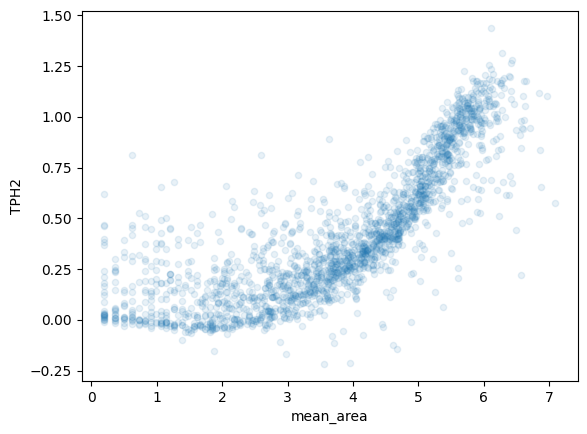

In [530]:
(treatment - null).assign(mean_area = mean_area.tolist()).plot.scatter(
    x="mean_area",
    y="TPH2",
    alpha = 0.1
)

# Changes cell type in the neighborhood.

In [4]:
import torch
from tqdm import tqdm
import random
import pandas as pd

import torch
import random
import numpy as np
import pandas as pd
from torch_geometric.utils import k_hop_subgraph
from tqdm import tqdm

def perform_neighbor_perturbation(
        adata,
        data,
        cell_type_testing,
        cell_type_perturb,
        category_mapping,
        nb_model
    ):

    indices = np.arange(adata.shape[0])[
        adata.obs["cell_type"].eq(cell_type_testing) 
        & 
        adata.obs["lipid_droplet_area"].gt(0)
        & 
        adata.obs["near_amyloid"].eq(0)
    ]

    nb_model.to(device)
    results = {}
    target_cell_type = category_mapping[cell_type_perturb]

    # full edge index
    edge_index = data.edge_index

    for idx in indices:
        # extract 2-hop subgraph
        subset, sub_edge_index, mapping, _ = k_hop_subgraph(
            torch.tensor([idx]), 
            num_hops=2, 
            edge_index=edge_index, 
            relabel_nodes=True
        )

        # remap everything to local subgraph
        cell_type_clone = data.cell_type_encoded[subset].clone()
        lipid_droplet_area = data.lipid_droplet_area[subset]

        center_idx = mapping.item()  # local index of target cell
        num_nodes = len(subset)

        # Find neighbors within the subgraph (1-hop)
        neighbors = sub_edge_index[1][sub_edge_index[0] == center_idx].tolist()
        if not neighbors:
            continue  # skip if isolated

        chosen_neighbor = random.choice(neighbors)
        i = 0
        while (cell_type_clone[chosen_neighbor].argmax() == target_cell_type) and i < 10:
            chosen_neighbor = random.choice(neighbors)
            i += 1

        # Replace cell type
        cell_type_clone[chosen_neighbor][cell_type_clone[chosen_neighbor].argmax()] = 0
        cell_type_clone[chosen_neighbor][target_cell_type] = 1

        # Run model on subgraph
        nb_model.eval()
        with torch.no_grad():
            logits, _ = nb_model(
                cell_type_clone.int().to(device),
                lipid_droplet_area.to(device),
                sub_edge_index.to(device)
            )

        results[idx] = logits[center_idx].cpu().detach()

    # Compile treatment effect
    treatment = pd.DataFrame(results, index=adata.var_names).T

    # Null model using full graph
    logits, _ = nb_model(
        data.cell_type_encoded.int().to(device), 
        data.lipid_droplet_area.to(device), 
        data.edge_index.to(device)
    )

    null = pd.DataFrame(
        logits[treatment.index].cpu().detach().numpy(), 
        index=treatment.index, 
        columns=adata.var_names
    )

    return treatment - null

In [ ]:

pairwise_testing = {
    cell_type: {
        cell_type_perturb: perform_neighbor_perturbation(adata, data, cell_type, cell_type_perturb, category_mapping, nb_model)
        for cell_type_perturb in adata.obs.query('cell_type != @cell_type')["cell_type"].unique()
    }
    for cell_type in tqdm(adata.obs["cell_type"].unique())
}

In [471]:
outcomes = []

for cell_type in adata.obs["cell_type"].unique():
    mean_expression = pd.Series(
        adata[adata.obs["cell_type"].eq(cell_type)].X.mean(axis=0),
        index=adata.var_names
    )

    for cell_type_perturb, average_treatment_effect in pairwise_testing[cell_type].items():
        if average_treatment_effect.shape[0] > 200:
            aggregate = {
                "cell_type": cell_type,
                "cell_type_perturb": cell_type_perturb,
                "effect":  (average_treatment_effect.mean(axis=0))[mean_expression > 0.5].abs().sum(), 
            }
            per_gene = {
                gene: (average_treatment_effect[gene].mean() if (mean_expression.loc[gene] > 0.5) else None)
                for gene in average_treatment_effect.columns
            }
            aggregate.update(per_gene)
            outcomes.append(aggregate)


<Axes: xlabel='cell_type_perturb', ylabel='cell_type'>

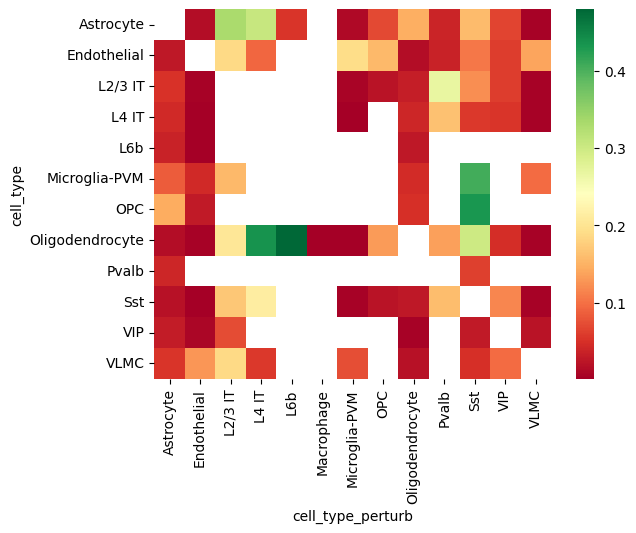

In [472]:
import seaborn as sns
heatmap = pd.DataFrame(outcomes).pivot_table(index="cell_type", columns="cell_type_perturb", values="effect")
sns.heatmap(heatmap, cmap="RdYlGn")

<Axes: xlabel='cell_type_perturb', ylabel='cell_type'>

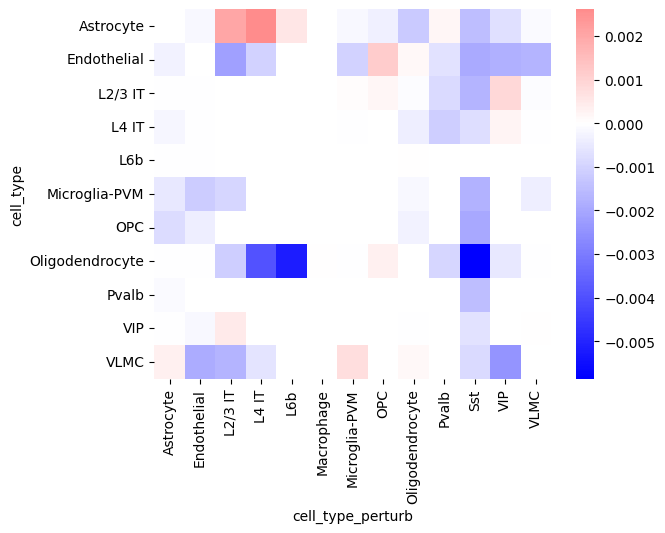

In [486]:
import seaborn as sns
heatmap = pd.DataFrame(outcomes).pivot_table(
    index="cell_type", 
    columns="cell_type_perturb", 
    values="LAMP1"
)
sns.heatmap(heatmap, cmap="bwr", center=0)

# What's the effect of inducing lipid droplet changes in a cell.

- Suppose we want to see what the effect is on a cell if we change the amount of lipid in its' neighboring cells, where will the effect be strongest.

In [5]:
import torch
import random
import numpy as np
import pandas as pd
from torch_geometric.utils import k_hop_subgraph
from tqdm import tqdm

def perform_neighbor_lipid_perturbation(
    adata, 
    data, 
    cell_type_testing, 
    cell_type_perturb, 
    category_mapping,
    new_lipid_value=0.0, 
    min_lipid_size=4.0
):
    # Todo: adjust so that we can add new bounds, question addition vs removal of lipid droplet.
    indices = np.arange(adata.shape[0])[
        adata.obs["cell_type"].eq(cell_type_testing) 
        & 
        adata.obs["lipid_droplet_area"].gt(0.0)
        & 
        adata.obs["near_amyloid"].eq(0)
    ]


    nb_model.to(device)
    results = {}
    target_cell_type = category_mapping[cell_type_perturb]
    edge_index = data.edge_index

    for idx in indices:
        # extract 2-hop subgraph
        subset, sub_edge_index, mapping, _ = k_hop_subgraph(
            torch.tensor([idx]), 
            num_hops=2, 
            edge_index=edge_index, 
            relabel_nodes=True
        )

        # Get subgraph feature tensors
        cell_type_clone = data.cell_type_encoded[subset].clone()
        lipid_droplet_area = data.lipid_droplet_area[subset].clone()

        center_idx = mapping.item()  # local index of target cell

        # Find matching cell type in subgraph (excluding the target)
        candidate_indices = [
            i for i in range(len(subset))
            if ((i != center_idx) & (cell_type_clone[i].argmax().item() == target_cell_type) & (lipid_droplet_area[i] > min_lipid_size))
        ]

        if not candidate_indices:
            continue  # skip if no perturbable cell found

        chosen_perturb_idx = random.choice(candidate_indices)

        # Replace lipid droplet value of that cell
        lipid_droplet_area[chosen_perturb_idx] = new_lipid_value

        # Run model on subgraph
        nb_model.eval()
        with torch.no_grad():
            logits, _ = nb_model(
                cell_type_clone.int().to(device),
                lipid_droplet_area.to(device),
                sub_edge_index.to(device)
            )

        results[idx] = logits[center_idx].cpu().detach()

    # Compile treatment effect
    treatment = pd.DataFrame(results, index=adata.var_names).T

    # Null model using full graph
    logits, _ = nb_model(
        data.cell_type_encoded.int().to(device), 
        data.lipid_droplet_area.to(device), 
        data.edge_index.to(device)
    )

    null = pd.DataFrame(
        logits[treatment.index].cpu().detach().numpy(), 
        index=treatment.index, 
        columns=adata.var_names
    )

    return treatment - null


In [ ]:

pairwise_testing = {
    cell_type: {
        cell_type_perturb: perform_neighbor_lipid_perturbation(
            adata, 
            data, 
            cell_type, 
            cell_type_perturb, 
            category_mapping,
            new_lipid_value=0.0
        )
        for cell_type_perturb in adata.obs.query('cell_type != @cell_type')["cell_type"].unique()
    }
    for cell_type in tqdm(adata.obs["cell_type"].unique())
}

In [490]:
outcomes = []

for cell_type in adata.obs["cell_type"].unique():
    mean_expression = pd.Series(
        adata[adata.obs["cell_type"].eq(cell_type)].X.mean(axis=0),
        index=adata.var_names
    )

    for cell_type_perturb, average_treatment_effect in pairwise_testing[cell_type].items():
        if average_treatment_effect.shape[0] > 200:
            aggregate = {
                "cell_type": cell_type,
                "cell_type_perturb": cell_type_perturb,
                "effect":  (mean_expression * average_treatment_effect.mean(axis=0)).abs().sum(), 
            }
            per_gene = {
                gene: (average_treatment_effect[gene].mean() if mean_expression.loc[gene] > .5 else 0)
                for gene in average_treatment_effect.columns
            }
            aggregate.update(per_gene)
            outcomes.append(aggregate)

<Axes: xlabel='cell_type_perturb', ylabel='cell_type'>

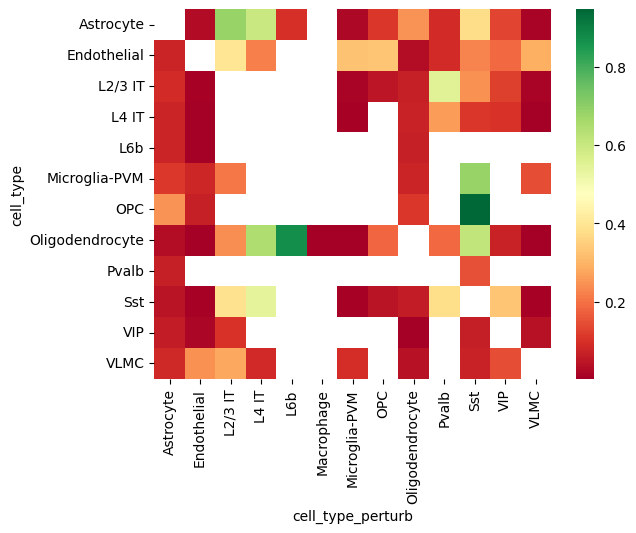

In [491]:
import seaborn as sns
heatmap = pd.DataFrame(outcomes).pivot_table(index="cell_type", columns="cell_type_perturb", values="effect")
sns.heatmap(heatmap, cmap="RdYlGn")

# Generalized Pipeline

In [6]:
# Pipeline to test all specimens:
import os
import pickle
import torch
import wandb
import scanpy as sc
import torch.distributions as dist
from IPython.display import clear_output

# AnnData
adata = sc.read_h5ad("/home/jhaberbe/Projects/Personal/ate/data/lipid-droplet.h5ad")
for folder in adata.obs["folder"].unique()[6:]:
    adata = sc.read_h5ad("/home/jhaberbe/Projects/Personal/ate/data/lipid-droplet.h5ad")
    adata = adata[adata.obs["folder"].eq(folder)]
    adata = adata[adata.layers["transcript"].sum(axis=1) > 20]

    # Data Setup
    data = utils.generate_torch_geometric_data(adata)
    data.counts = torch.tensor(adata.layers["transcript"], dtype=torch.float32)
    data.near_amyloid = torch.tensor(adata.obs["near_amyloid"].values, dtype=torch.float32)
    data.lipid_droplet_area = torch.tensor(adata.obs["lipid_droplet_area"].values, dtype=torch.float32)
    data.total_counts = torch.tensor(adata.layers["transcript"].sum(axis=1))
    data.size_factors = utils.counts_to_size_factors(data.total_counts)
    data.cell_type_encoded = torch.tensor(pd.get_dummies(adata.obs["cell_type"].cat.codes).astype(float).values)

    category_mapping = {cat: code for code, cat in enumerate(adata.obs["cell_type"].cat.categories)}
    category_mapping

    # Model Setup
    nb_model = models.JointEmbeddingGATv2NBNet(len(category_mapping), 64, 64, data.x.shape[1])

    # Send to proper devices.
    device = "cuda"
    data.to(device)
    nb_model.to(device)

    # Training routine.
    optimizer = torch.optim.Adam(nb_model.parameters(), lr=1e-4, weight_decay=1e-4)
    num_epochs = 10_000

    wandb.init(project="ate", name=f"{folder}")

    for epoch in range(num_epochs):
        nb_model.train()
        optimizer.zero_grad()

        logits, dispersion = nb_model(
            data.cell_type_encoded.int(), 
            data.lipid_droplet_area, 
            data.edge_index
        )

        nb_dist = dist.NegativeBinomial(
            logits=logits + data.size_factors.repeat(logits.shape[1], 1).T,
            total_count=dispersion
        )
        log_likelihood = nb_dist.log_prob(data.counts).sum(axis=1).mean()
        loss = -log_likelihood
        loss.backward()
        optimizer.step()
        wandb.log({"epoch": epoch + 1, "loss": loss.item(), "log_likelihood": log_likelihood.item()})
        if epoch % 100 == 0:
            print({"epoch": epoch + 1, "loss": loss.item(), "log_likelihood": log_likelihood.item()})

    torch.save(nb_model.state_dict(), f"../models/{folder}.pth")
    nb_model.load_state_dict(torch.load(f"../models/{folder}.pth"))

    lipid_perturbation = {
        cell_type: perform_lipid_perturbation(adata, data, cell_type, nb_model)
        for cell_type in adata.obs["cell_type"].unique()
    }

    neighbor_perturbation = {
        cell_type: {
            cell_type_perturb: perform_neighbor_perturbation(adata, data, cell_type, cell_type_perturb, category_mapping, nb_model)
            for cell_type_perturb in adata.obs.query('cell_type != @cell_type')["cell_type"].unique()
        }
        for cell_type in tqdm(adata.obs["cell_type"].unique())
    }

    neighbor_lipid_perturbation = {
        cell_type: {
            cell_type_perturb: perform_neighbor_lipid_perturbation(
                adata, 
                data, 
                cell_type, 
                cell_type_perturb, 
                category_mapping,
                new_lipid_value=0.0
            )
            for cell_type_perturb in adata.obs.query('cell_type != @cell_type')["cell_type"].unique()
        }
        for cell_type in tqdm(adata.obs["cell_type"].unique())
    }

    # Ensure the output directory exists
    os.makedirs(f"/home/jhaberbe/Projects/Personal/ate/output/{folder}", exist_ok=True)

    with open(f"/home/jhaberbe/Projects/Personal/ate/output/{folder}/lipid_perturbation.pickle", "wb") as f:
        pickle.dump(lipid_perturbation, f)

    with open(f"/home/jhaberbe/Projects/Personal/ate/output/{folder}/neighbor_perturbation.pickle", "wb") as f:
        pickle.dump(neighbor_perturbation, f)

    with open(f"/home/jhaberbe/Projects/Personal/ate/output/{folder}/neighbor_lipid_perturbation.pickle", "wb") as f:
        pickle.dump(neighbor_lipid_perturbation, f)

    clear_output()

# Perturb Differences

In [7]:
import pickle
import pathlib

per_folder_lipid_impact = {
    folder.name: pickle.load(open(folder/"lipid_perturbation.pickle", "rb"))
    for folder in pathlib.Path("/home/jhaberbe/Projects/Personal/ate/output").glob("*")
}

In [43]:
from sklearn.metrics.pairwise import rbf_kernel
from scipy.interpolate import UnivariateSpline

def fit_spline(df, gene="PLIN2"):
    X = df[gene]
    y = df["mean_area"]
    sorted_index = y.sort_values().index
    X = X.loc[sorted_index]
    y = y.loc[sorted_index]
    return UnivariateSpline(y, X)

def compute_spline_covariance(fitted_splines: list, sigma = 0.5):
    spline_matrix = np.stack([spline(np.linspace(0, 7, 200)) for spline in fitted_splines])

    pairwise_dists = np.linalg.norm(
        spline_matrix[:, None, :] - spline_matrix[None, :, :], axis=2
    )
    median_dist = np.median(pairwise_dists)
    sigma = median_dist if median_dist > 0 else sigma
    K = rbf_kernel(spline_matrix, gamma=1/(2*sigma**2))

    return spline_matrix, K - np.eye(K.shape[0])

computed_splines = {}
for gene in adata.var_names:
    gene_splines =  [fit_spline(per_folder_lipid_impact[folder]["Astrocyte"], gene=gene) for folder in per_folder_lipid_impact]
    computed_splines[gene] = compute_spline_covariance(gene_splines)

np.float64(33.05272077095715)

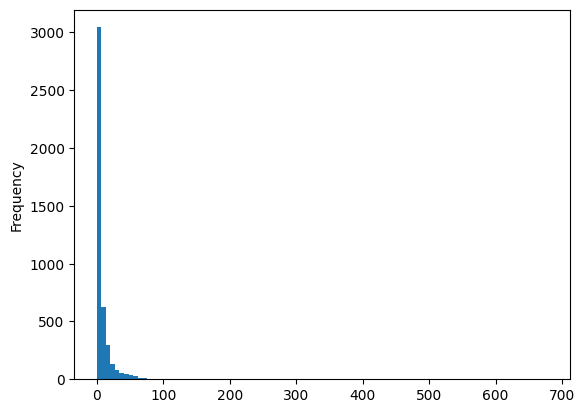

In [65]:
import numpy as np
from statsmodels.tsa.stattools import kpss
import numpy as np

def is_nonstationary(ts, threshold=35):
    """
    Returns True if the residual sum of squares from the mean exceeds a threshold.
    """
    mean = np.mean(ts)
    rss = np.sum((ts - mean) ** 2)
    return rss > threshold

import numpy as np
import pandas as pd

def compute_rss_residuals_per_sample(gene_data_dict):
    """
    For each gene and sample, compute the residual sum of squares (RSS)
    from the mean (i.e., how much the sample's time series deviates from flatness).

    Parameters:
        gene_data_dict: dict
            { gene_name: (data_matrix, covariance_matrix) }
            data_matrix: shape (n_samples, n_timepoints)

    Returns:
        pd.Series with MultiIndex (gene_name, sample_index)
    """
    rss_records = []

    for gene, (data, _) in gene_data_dict.items():
        for i, ts in enumerate(data):
            mean_val = np.mean(ts)
            rss = np.sum((ts - mean_val) ** 2)
            rss_records.append(((gene, i), rss))

    index = pd.MultiIndex.from_tuples([k for k, _ in rss_records], names=["gene", "sample"])
    values = [v for _, v in rss_records]

    return pd.Series(values, index=index, name="RSS")

compute_rss_residuals_per_sample(computed_splines).plot.hist(bins=100)
compute_rss_residuals_per_sample(computed_splines).quantile(.95)

In [96]:
def find_nonflat_high_cov_genes(
    gene_data_dict,
    rss_threshold=33,
    cov_threshold=0.5,
    min_nonflat_samples=2
):
    """
    Parameters:
        gene_data_dict: dict
            { gene_name: (data_matrix, covariance_matrix) }
            data_matrix: shape (n_samples, n_timepoints)
            covariance_matrix: shape (n_samples, n_samples)
        rss_threshold: float
            Threshold for residual sum of squares from the mean
        cov_threshold: float
            Minimum average covariance between nonflat samples
        min_nonflat_samples: int
            Minimum number of non-flat samples required to consider the gene
    
    Returns:
        result_dict: dict
            { gene_name: [sample indices] } for genes meeting the criteria
    """
    result = {}

    for gene, (data, cov) in gene_data_dict.items():
        n_samples = data.shape[0]

        # Step 1: Test each sample for deviation from mean (non-flatness)
        nonflat_idxs = [
            i for i in range(n_samples) if is_nonflat(data[i], threshold=rss_threshold)
        ]

        # Step 2: Check count
        if len(nonflat_idxs) < min_nonflat_samples:
            continue

        # Step 3: Extract submatrix of covariances
        cov_subset = cov[np.ix_(nonflat_idxs, nonflat_idxs)]
        upper_tri_val


def find_nonstationary_high_cov_genes(
    gene_data_dict, 
    alpha=0.05, 
    cov_threshold=0.6, 
    min_nonstationary_samples=6
):
    """
    Parameters:
        gene_data_dict: dict
            { gene_name: (data_matrix, covariance_matrix) }
            data_matrix: shape (n_samples, n_timepoints)
            covariance_matrix: shape (n_samples, n_samples)
        alpha: float
            Significance level for non-stationarity (KPSS)
        cov_threshold: float
            Minimum average covariance between nonstationary samples
        min_nonstationary_samples: int
            Minimum number of non-stationary samples required to consider the gene
    
    Returns:
        result_dict: dict
            { gene_name: [sample indices] } for genes meeting the criteria
    """
    result = {}

    for gene, (data, cov) in gene_data_dict.items():
        n_samples = data.shape[0]

        # Step 1: Test each sample for non-stationarity
        nonstationary_idxs = [
            i for i in range(n_samples) if is_nonstationary(data[i], alpha)
        ]

        # Step 2: Check count
        if len(nonstationary_idxs) < min_nonstationary_samples:
            continue

        # Step 3: Extract submatrix of covariances
        cov_subset = cov[np.ix_(nonstationary_idxs, nonstationary_idxs)]
        upper_tri_vals = cov_subset[np.triu_indices(len(nonstationary_idxs), k=1)]

        # Step 4: Compute average covariance
        if len(upper_tri_vals) == 0:
            continue  # only 1 nonstationary sample
        avg_cov = np.mean(upper_tri_vals)

        if avg_cov > cov_threshold:
            result[gene] = nonstationary_idxs

    return result

find_nonstationary_high_cov_genes(computed_splines)

{'CDH12': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 'MYO5B': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 'OPALIN': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 'SRGN': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]}

In [97]:
import numpy as np

def find_genes_with_cov_and_rss(
    gene_data_dict,
    cov_threshold=0.6,
    min_cov_connections=10,
    rss_threshold=50.0,
    min_rss_samples=6
):
    """
    Parameters:
        gene_data_dict: dict
            { gene_name: (data_matrix, covariance_matrix) }
            data_matrix: shape (n_samples, n_timepoints)
            covariance_matrix: shape (n_samples, n_samples)
        cov_threshold: float
            Minimum covariance to consider two samples as connected
        min_cov_connections: int
            Minimum number of lower triangle cov values above the threshold
        rss_threshold: float
            Minimum RSS from zero to consider a sample non-flat
        min_rss_samples: int
            Minimum number of such non-flat samples required
    
    Returns:
        result: dict
            { gene_name: [indices of high-RSS samples] }
    """
    result = {}

    for gene, (data, cov) in gene_data_dict.items():
        n_samples = data.shape[0]

        # Step 1: Count lower triangle covariances > threshold
        tril_indices = np.tril_indices(n_samples, k=-1)
        cov_values = cov[tril_indices]
        num_high_cov = np.sum(cov_values > cov_threshold)

        if num_high_cov < min_cov_connections:
            continue  # too few connections

        # Step 2: Find which samples have RSS from 0 > rss_threshold
        rss_values = np.sum((data - 0.0) ** 2, axis=1)
        high_rss_indices = np.where(rss_values > rss_threshold)[0]

        if len(high_rss_indices) < min_rss_samples:
            continue  # too few expressive samples

        result[gene] = high_rss_indices.tolist()

    return result

find_genes_with_cov_and_rss(computed_splines)

{'ANO3': [1, 4, 7, 8, 9, 11],
 'CD48': [1, 2, 4, 6, 7, 10],
 'CRYM': [0, 1, 4, 5, 8, 9, 11],
 'HS3ST2': [2, 4, 7, 8, 9, 10, 11],
 'MS4A6A': [1, 2, 4, 6, 7, 8],
 'NLRP3': [1, 4, 5, 6, 7, 8],
 'ROS1': [1, 4, 5, 7, 9, 11],
 'SAMD5': [1, 2, 4, 5, 7, 8, 9],
 'SFRP2': [4, 6, 7, 9, 10, 11],
 'SLC17A6': [1, 4, 5, 8, 9, 10, 11],
 'SST': [0, 3, 4, 5, 9, 10, 11],
 'ST18': [2, 4, 5, 6, 7, 8, 11]}

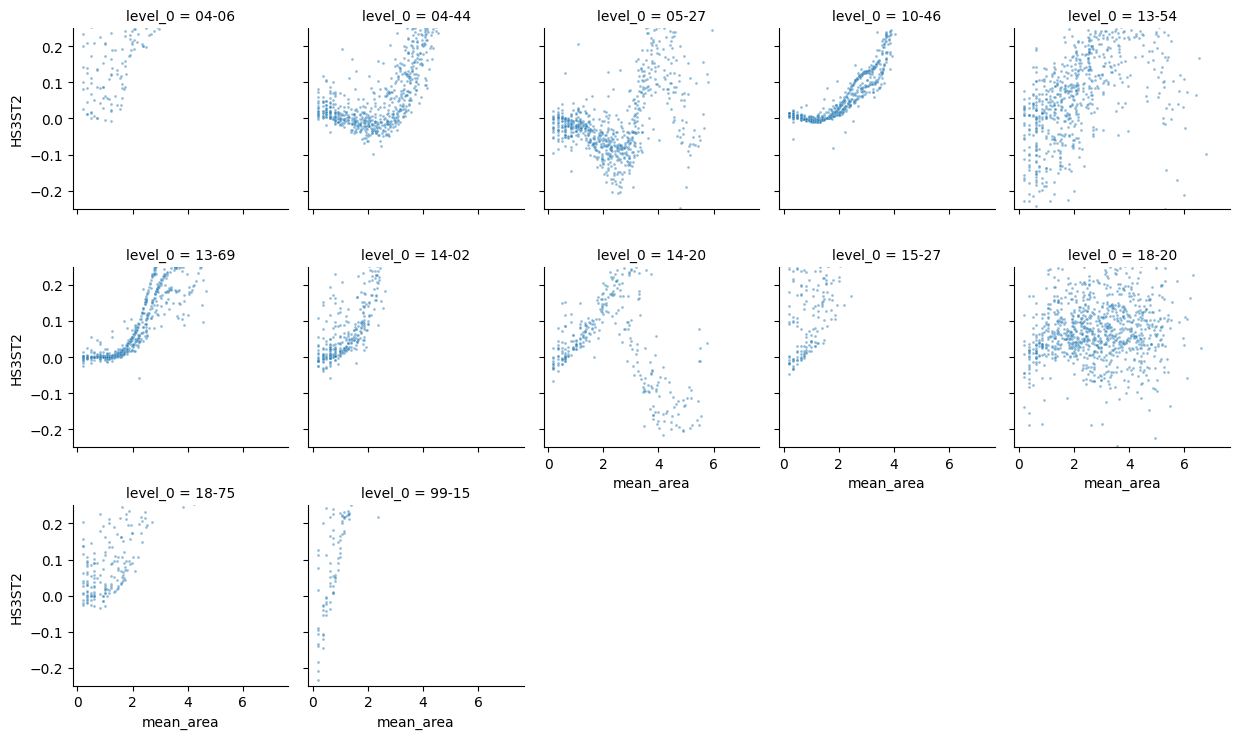

In [95]:
import seaborn as sns

combined_impacts = pd.concat({folder: per_folder_lipid_impact[folder]["Microglia-PVM"] for folder in per_folder_lipid_impact}) \
    .reset_index() \
    .drop("level_1", axis=1)
combined_impacts = combined_impacts.sort_values(by="level_0")

import seaborn as sns
import matplotlib.pyplot as plt

g = sns.FacetGrid(
    combined_impacts,
    col="level_0",
    col_wrap=5,  # adjust based on how many subplots per row you want
    height=2.5,
    sharex=True,
    sharey=True
)

g.map_dataframe(
    sns.scatterplot,
    x="mean_area",
    y="HS3ST2",
    alpha=0.5,
    s=4,
    color="tab:blue"  # you can also vary this with hue if needed
)

# Set y-limits on all subplots
for ax in g.axes.flat:
    ax.set_ylim(-0.25, 0.25)

g.tight_layout()
plt.show()


In [54]:
adata.obs.drop_duplicates(subset=["folder"])[["folder", "group"]].sort_values(by="folder")

,folder,group
cell_id,,
aaabikmi-1,04-06,AD 44
aaaaegai-1,14-20,ND 33
aaaahejp-1,13-54,AD 33
aaaaapcl-1,05-27,AD 44
aaaacglc-1,15-27,AD 33
aaabchga-1,99-15,AD 44
aaaafefa-1,18-20,ND 33
aaaaioeb-1,18-75,ND 33
aaaamdhh-1,10-46,AD 33


## Random Thought
Good method to determine the covariance between multiple items, clustering by time.

In [ ]:
import numpy as np
from scipy.interpolate import UnivariateSpline, RBFInterpolator
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

gp = GaussianProcessRegressor(kernel=RBF(length_scale=0.5), alpha=1e-2)


cell_type = "Microglia-PVM"
sorted_index = per_folder_lipid_impact["05-27"][cell_type]["mean_area"].sort_values().index

fitted_splines = {}
for gene in tqdm(adata.var_names):
    X = per_folder_lipid_impact["05-27"][cell_type][gene].loc[sorted_index]
    y = per_folder_lipid_impact["05-27"][cell_type]["mean_area"].loc[sorted_index]
    gp.fit(y.values.reshape(-1, 1), X)
    fitted_splines[gene] = gp.predict(y.values.reshape(-1, 1))

spline_matrix = np.stack([spline(np.linspace(y.min(), y.max(), 200)) for spline in fitted_splines.values()])
dists = squareform(pdist(spline_matrix, metric='euclidean'))  # or 'sqeuclidean'

/home/jhaberbe/Projects/Personal/ate/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [ ]:
import numpy as np
from scipy.spatial.distance import cdist

def rbf_covariance(time_series, gamma=None):
    """
    Computes RBF kernel-based covariance between time series.

    Parameters:
        time_series: np.ndarray of shape (n_features, n_timepoints)
        gamma: float or None. If None, defaults to 1 / n_timepoints.

    Returns:
        cov: np.ndarray of shape (n_features, n_features)
    """
    n_features, n_timepoints = time_series.shape
    if gamma is None:
        gamma = 1.0 / n_timepoints

    # Pairwise squared Euclidean distances
    dists = cdist(time_series, time_series, metric='sqeuclidean')

    # Apply RBF kernel
    cov = np.exp(-gamma * dists)
    return cov

array([[1.        , 0.88153997, 0.98498957, ..., 0.89300042, 0.97296044,
        0.98685838],
       [0.88153997, 1.        , 0.81122192, ..., 0.9727392 , 0.90647511,
        0.93493455],
       [0.98498957, 0.81122192, 1.        , ..., 0.81446726, 0.96344267,
        0.96050427],
       ...,
       [0.89300042, 0.9727392 , 0.81446726, ..., 1.        , 0.8752607 ,
        0.92171834],
       [0.97296044, 0.90647511, 0.96344267, ..., 0.8752607 , 1.        ,
        0.99088732],
       [0.98685838, 0.93493455, 0.96050427, ..., 0.92171834, 0.99088732,
        1.        ]], shape=(366, 366))

/home/jhaberbe/Projects/Personal/ate/.venv/lib/python3.13/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/jhaberbe/Projects/Personal/ate/.venv/lib/python3.13/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


MBP       True
MOBP      True
NLRP3     True
SAMD5     True
ST18      True
CERCAM    True
CNDP1     True
dtype: bool

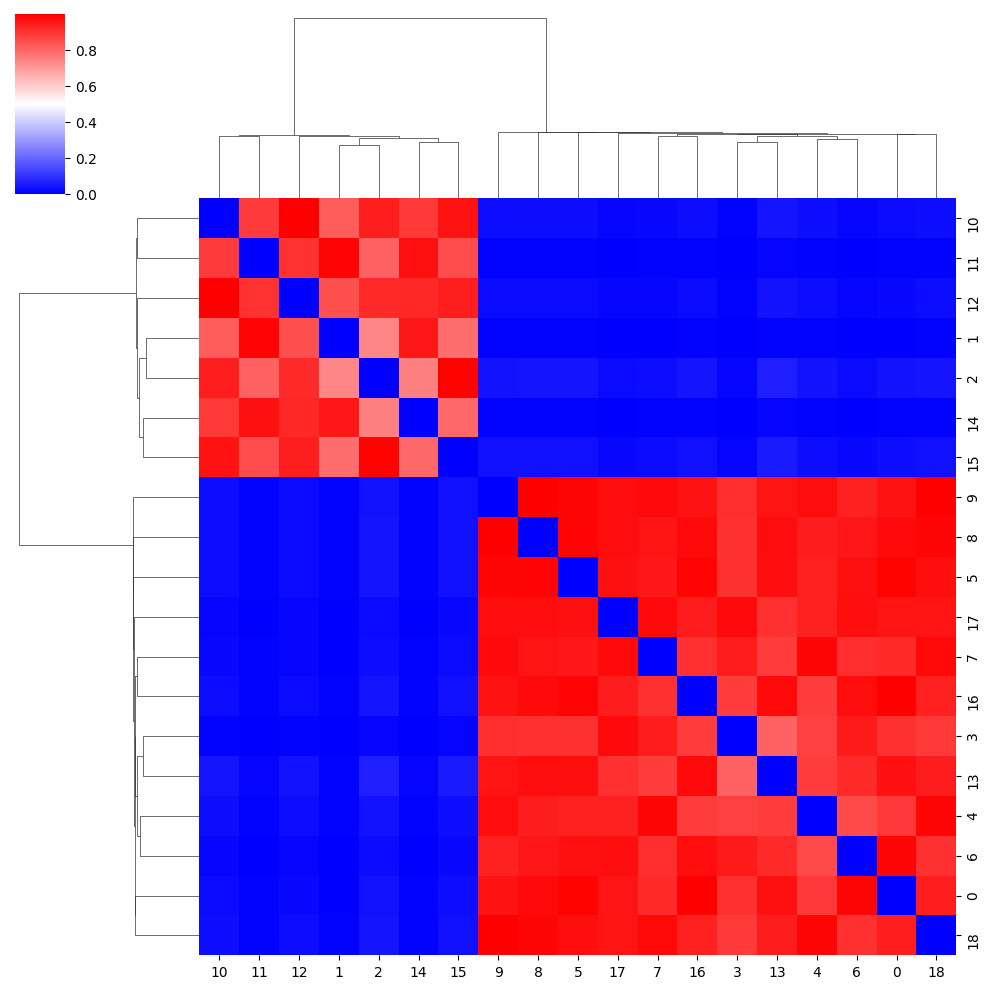

In [ ]:
indices = pd.Series((spline_matrix ** 2).sum(axis=1), index=adata.var_names) > pd.Series((spline_matrix ** 2).sum(axis=1)).quantile(.95)
sns.clustermap(
    rbf_covariance(spline_matrix[indices]) - np.eye(rbf_covariance(spline_matrix[indices]).shape[0]),
    cmap="bwr"
)

indices[indices].iloc[[10, 11, 12, 14, 15, 1, 2]]


<Axes: >

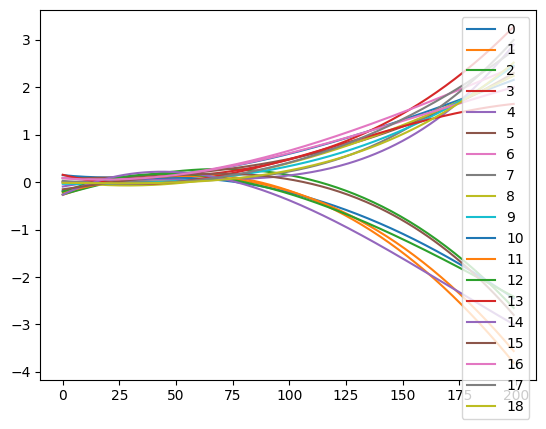

In [137]:
pd.DataFrame(spline_matrix[indices]).T.plot.line()

In [ ]:
from sklearn.cluster import SpectralClustering


n_clusters = 5  # set as needed
sc = SpectralClustering(n_clusters=n_clusters, random_state=0)
labels = sc.fit_predict(K - np.eye(K.shape[0]))

/home/jhaberbe/Projects/Personal/ate/.venv/lib/python3.13/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


In [144]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score

def spectral_clustering_best_k(kernel, k_min=2, k_max=10, verbose=False):
    best_k = None
    best_score = -1
    best_labels = None

    for k in range(k_min, k_max + 1):
        clustering = SpectralClustering(
            n_clusters=k, affinity='precomputed', random_state=0
        )
        labels = clustering.fit_predict(K)

        # Silhouette requires feature matrix or distance matrix.
        # Here use distance matrix derived from similarity
        dist_matrix = 1 - K  # similarity -> distance

        score = silhouette_score(dist_matrix, labels, metric='precomputed')

        if verbose:
            print(f"k={k}, silhouette score={score:.4f}")

        if score > best_score:
            best_score = score
            best_k = k
            best_labels = labels

    return best_k, best_labels, best_score

_, labels, _ = spectral_clustering_best_k(K, k_min=4, verbose=True)

k=4, silhouette score=0.2804
k=5, silhouette score=0.3823
k=6, silhouette score=0.3602
k=7, silhouette score=0.3812
k=8, silhouette score=0.3264
k=9, silhouette score=0.3687
k=10, silhouette score=0.3338
